In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from fbm import FBM
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from tqdm.auto import tqdm
from scipy.optimize import root_scalar

from importlib import reload
import realized_volatility
reload(realized_volatility)

import stochastic_volatility
reload(stochastic_volatility)

from stochastic_volatility import price_from_volatility
from realized_volatility import realized_volatility
from simulation import *
from hurst_estimation import m_estimator, w_estimator

# Volatility is rough (or maybe it is not)

### fBM

__Fractional brownian motion__ (fBM) with Hurst parameter $H \in (0,\, 1)$:
1. Gaussian process
2. $\mathbb{E}|W_{t+\Delta}^H - W_t^H|^q = K_q\Delta^{qH}$.

In [2]:
H_array = [0.15, 0.5, 0.85]
sample_size = 2048*4

fig = make_subplots(rows=len(H_array), cols=1)

for i, H in enumerate(H_array):
    f = FBM(n=sample_size, hurst=H, length=1, method='daviesharte')
    fBM = f.fbm()

    fig.add_trace(
        go.Scatter(x=f.times(), y=fBM, name=f'H={H}'),
        row=i + 1, col=1
    )

fig.update_layout(height=600, width=700, title_text="Fractional Brownian motion trajectories")
fig.show()

### Simulation: gBM volatility process 

In [3]:
gBM = simulate_gBM(10**6, sigma=1.2) * 0.1
fig = px.line(x=np.linspace(0, 1, gBM.size)[::100], y=gBM[::100])
fig.update_layout(height=400, width=600, title_text="Instantaneous volatility process")
fig.show()

In [4]:
X = price_from_volatility(gBM, x0=97.5)
t = np.linspace(0, 1, X.size)
fig = px.line(x=t[::100], y=X[::100])
fig.update_layout(height=400, width=600, title_text="Price process")
fig.show()

### Realized volatility estimation

Let $\pi$ denote a time grid
$$ 
\pi = \left(0 = t_0 < t_1 < \ldots < t_{N(\pi)}=1\right).
$$

The __realized volatility__ of a price price process $S$ over the interval $[t,\, t+\Delta]$ along the partition $\pi$ is defined as
$$
{\rm RV}_{t,t+\Delta}(\pi) = \sqrt{\sum_{\pi \cap [t,\,t+\Delta]}|X_{t_{i+1}} - X_{t_i}|^2} \approx \sqrt\Delta \sigma_t,
$$
where $X = \log S$.

In [5]:
rv = realized_volatility(X, n_est=150)

In [6]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Scatter(x=np.linspace(0, 1, 10**4), y=rv, name='Realized vol'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.linspace(0, 1, 10**6)[::100], y=gBM[::100], name='Instantaneous vol'),
    row=2, col=1
)

fig.update_layout(height=600, width=800, title_text="Realized and instantaneous volatilities")
fig.show()

### Estimating the smoothness (or roughness?)

Let's consider a trajectory $\sigma_t$ of volatility process. Assuming that its logarithm follows fBM, we can notice that

$$m(q, \Delta) = \dfrac{1}{N}\sum_{k=1}^N \big|\log(\sigma_{k\Delta}) - \log(\sigma_{(k-1)\Delta})\big|^q \approx K_q\Delta^{qH}.$$

Linear regression
$$ \log m(q, \Delta) = b + \zeta_q \log\Delta$$
provides the estimation $\zeta_q$ of the value $qH$.

Doing this calculations for different values of $q$, one finally obtain the estimation of $H$ based on the linear regression
$$\zeta_q = \hat H q.$$

In [7]:
fig = px.line(x=np.linspace(0, 1, rv.size), y=rv)

fig.update_layout(height=400, width=600, title_text="Volatility process (realized volatility)")
fig.show()

### Normal increments of log-volatility

In [8]:
fig = px.histogram(x=np.diff(np.log(rv)), histnorm='probability density')

mu, s = np.diff(np.log(rv)).mean(), np.diff(np.log(rv)).std()
x_grid = np.linspace(-0.3, 0.3, 100)

fig.add_scatter(x=x_grid, y=norm.pdf(x_grid, loc=mu, scale=s), mode='lines', name='Normal pdf')

fig.update_layout(height=400, width=600, title_text="Distribution of volatility log-increments")

fig.show()

0.13110689299004652

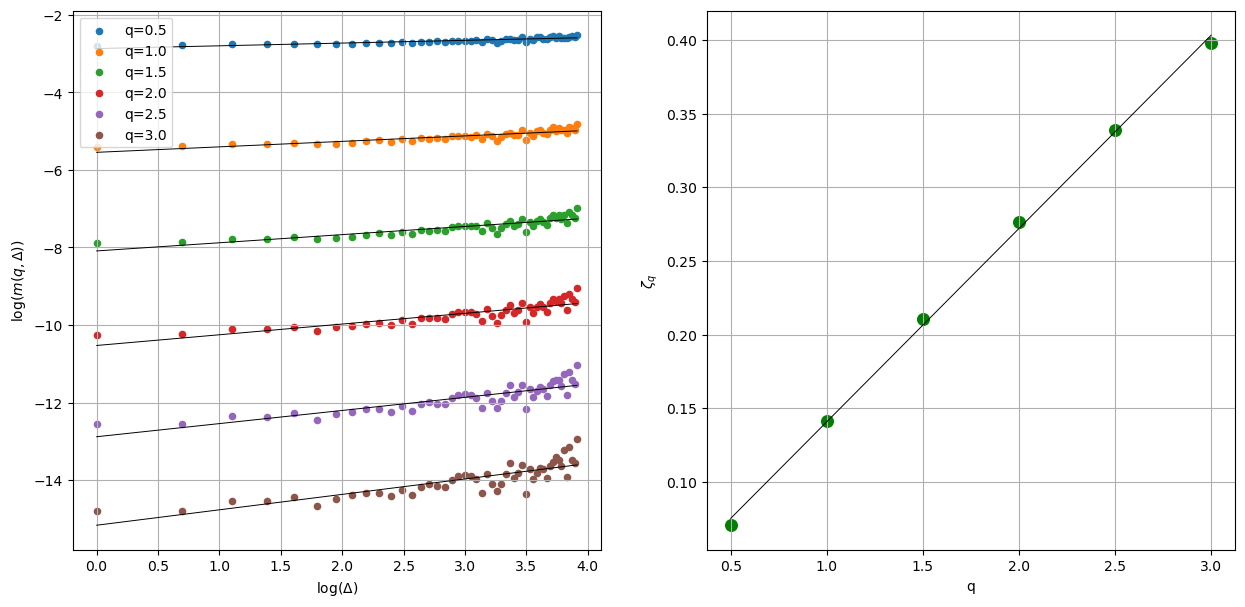

In [10]:
# without intersection
m_estimator(rv, is_plotting=True)

### Market data

In [24]:
df = pd.read_csv('../data/oxfordmanrealizedvolatilityindices.csv')
df = df.loc[df.Symbol == '.SPX'].reset_index(drop=True)

vol_proc = np.array(np.sqrt(df.rv5))
vol_proc10 = np.array(np.sqrt(df.rv10))

In [25]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Scatter(x=df['Unnamed: 0'], y=vol_proc, name='Realized volatility'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df['Unnamed: 0'], y=np.log(vol_proc), name='log(Realized volatility)'),
    row=2, col=1
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))


fig.update_layout(height=600, width=800)
fig.show()

0.1518579932412067

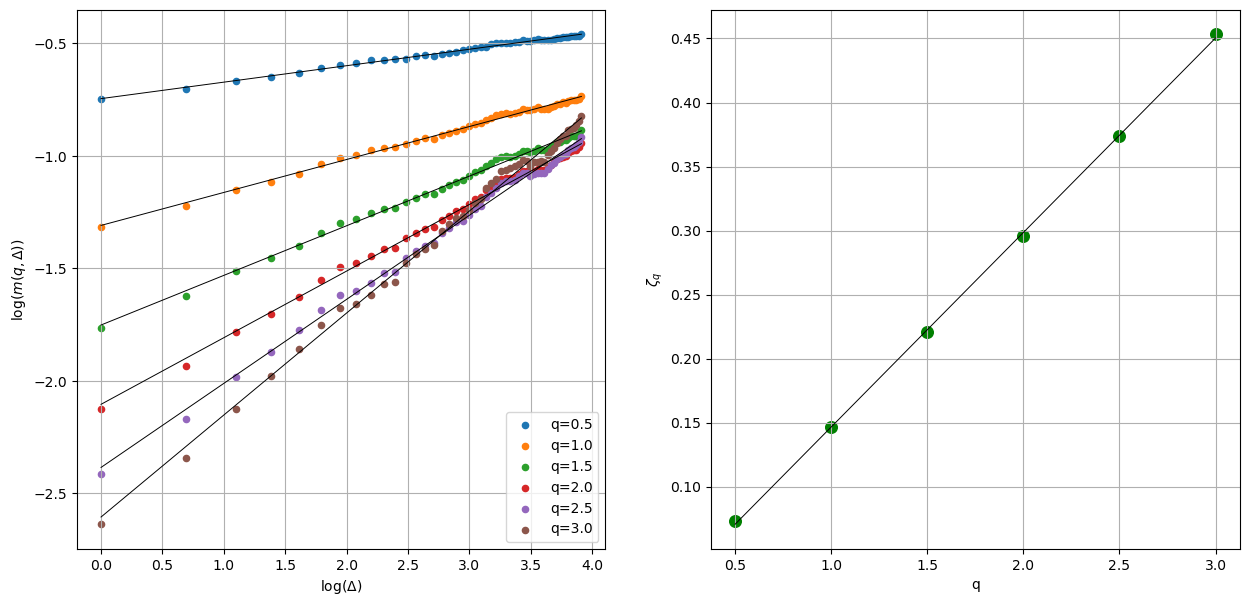

In [49]:
m_estimator(np.log(vol_proc), is_plotting=True, intersect=True)

In [50]:
# Estimation via normalized variation (w-estimation)
w_estimator(np.log(vol_proc), K = 60)

0.14478406367825303

In [51]:
fig = px.histogram(x=np.diff(np.log(vol_proc)), histnorm='probability density')

mu, s = np.diff(np.log(vol_proc)).mean(), np.diff(np.log(vol_proc)).std()
x_grid = np.linspace(-1.5, 1.5, 100)

fig.add_scatter(x=x_grid, y=norm.pdf(x_grid, loc=mu, scale=s), mode='lines', name='Normal pdf')

fig.update_layout(height=400, width=600, title_text="Distribution of volatility log-increments")

fig.show()

### Fractional Brownian Motion

In [53]:
H = 0.13
f = FBM(n=4096, hurst=H, length=1, method='daviesharte')
gfBM = np.exp(f.fbm())
fig = px.line(x=f.times(), y=fBM)
fig.update_layout(height=400, width=600, title_text=f"Fractional Brownian motion with H={H}")
fig.show()

0.12259368013855775

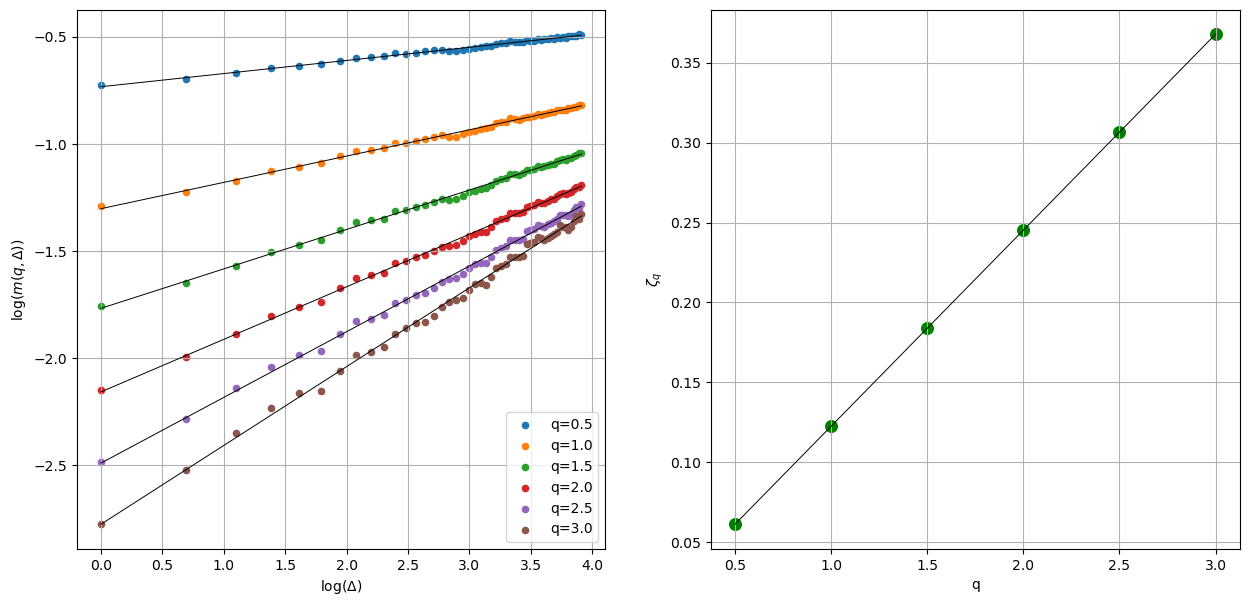

In [54]:
# without intersection
m_estimator(np.log(gfBM), is_plotting=True, intersect=True)

In [57]:
# Estimation via normalized variation (w-estimation)
w_estimator(np.log(fBM), K = 64) 

0.14040236720129542

### OU-OU model

$$
\begin{cases}
dY_t = \sigma_Y\,dW'_t - \beta Y_t \, dt, \\
dX_t = \sigma_X\,dW_t + \lambda(Y_t - X_t)\,dt
\end{cases}
$$

In [58]:
# parameters initialization
n_days = 5000
sigma_x = 0.3
sigma_y = 0.05
lam_x = 0.3
lam_y = 0.005
init = -7.2
mu = -7.2

#### OU-OU sampling

In [59]:
OUOU, Y = simulate_OUOU(n_sample=n_days,
                        sigma_x=sigma_x,
                        sigma_y=sigma_y,
                        lam=lam_x,
                        beta=lam_y,
                        T=n_days,
                        mu=mu,
                        init=init)
fig = px.line()
fig.add_scatter(y=OUOU, name='OUOU')
fig.add_scatter(y=Y, name='Y')
# fig.add_scatter(y=np.log(vol_proc), name='Y')

fig.update_layout(height=600, width=800, title_text="OU-OU trajectory")
fig.show()

In [60]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Scatter(x=df['Unnamed: 0'], y=np.exp(OUOU), name='exp(OUOU)'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df['Unnamed: 0'], y=OUOU, name='OUOU'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df['Unnamed: 0'], y=Y, name='Y'),
    row=2, col=1
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))


fig.update_layout(height=600, width=800)
fig.show()

In [62]:
m_estimator(OUOU, is_plotting=True, intersect=True)

0.1107925905671531

In [67]:
# Estimation via normalized variation (w-estimation)
w_estimator(OUOU) 

0.17710224476277284

### Another approach to roughness estimation

Let $[x]_{\pi}^{(p)}$ denote the $p$-th variation of the process $x$ along the partition sequence $\pi = (\pi_n)$ with  $|\pi_n| \to 0$.

Process $x \in V_\pi^p$ is said to have __normalized p-th variation__ along $\pi$ if there exists a continuous function $w(x, p, \pi)(\cdot)$ such that
$$
\forall t \in [0,\, T],\ \sum_{\pi_n \cap [0,\,t]}\dfrac{|x(t_{i+1}^n) - x(t_i^n)|^p}{[x]_\pi^{(p)}(t_{i+1}^n) - [x]_\pi^{(p)}(t_i^n)}(t_{i+1}^n - t_i^n) \overset{n\to\infty}{\longrightarrow} w(x, p, \pi)(t)
$$

It can be shown that if $x \in V_\pi^p$ for some $p > 1$ and the $p$-th variation is absolutely continuous then there exists the normalized $p$-variation
$$
\forall t \in (0,\, T],\ 
w(x, q, \pi)(t) = 
\begin{cases}
\infty, & q > p \\
t, & q = p \\
0, & q < p
\end{cases}
$$

Stochastic integrals of adapted quadratically integrable processes and fractional Brownian motions have linear normalized variation (of order 2 and $1/H$ respectievely) along the dyadic partition sequence almost surely. 

##### How to estimate the variation?

Given observations on a time partition $\pi_L$ we consider a subpartition $\pi_K$ (with $K \ll L$), which divide $\pi_L$ into $K$ groups of size $\dfrac{L}{K}$.

1. For different values of $p$ estimate the normalized $p$-th variation
$$
W(L, K, \pi, p, t, X) = \sum_{\pi^K \cap [0,\,T]}\dfrac{|X(t_{i+1}^K) - X(t_i^K)|^p}{\sum\limits_{\pi^L \cap [t_i^K,\,t_{i+1}^K]}{|X(t_{j+1}^L) - X(t_j^L)|^p}}(t_{i+1}^K - t_i^K). \\
$$
2. The variation index estimator $\hat p$ is obtained via solving the equation
$$
W(L, K, \pi, \hat p, T, X) = T.
$$
3. Roughness index estimator is defined as 
$$ \hat H = \dfrac{1}{\hat p}. $$

It was empirically shown that the most stable results are obtained when $K \approx \sqrt{L}$.

#### Estimation of $H$ for fBM with $H \in \{0.1,\, 0.3,\, 0.5,\, 0.8\}$.

### Fractional OU model
$$
\begin{cases}
dS_t = \sigma_t S_t\,dB_t, \sigma_t = \sigma_0e^{Y_t}, \\
dY_t = -\gamma Y_t\, dt + \theta\, dB_t^H.
\end{cases}
$$

Here $\sigma_0 = \theta = \gamma = 1,\ Y_0 = 0$.

#### Simulated prices, realized and instantaneous volatilities

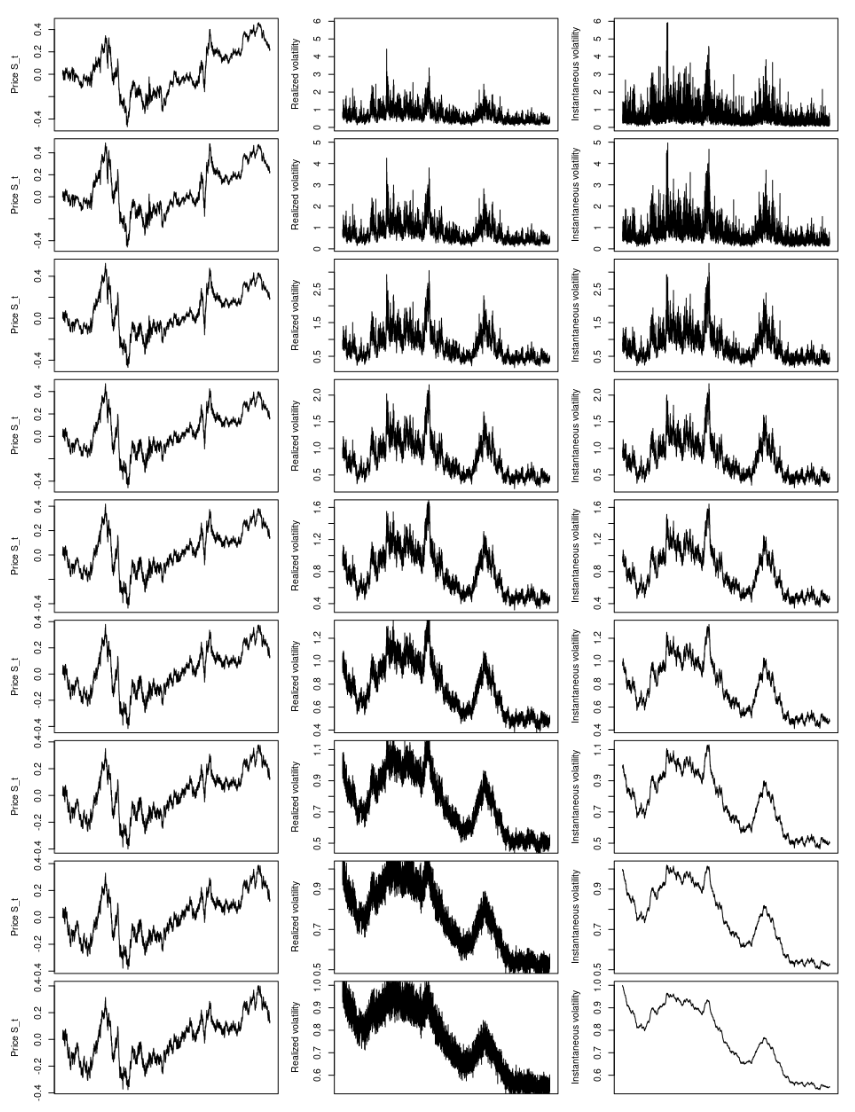

#### Estimations of $H$

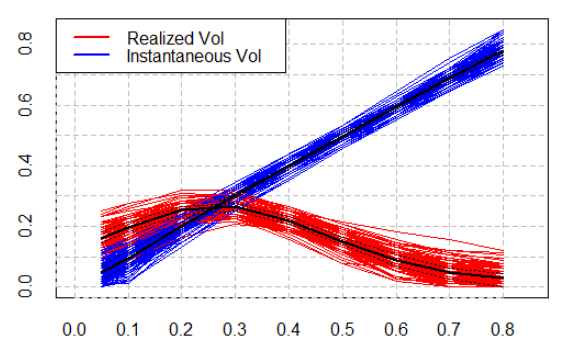

### Another argument in favor if roughness: ATM skew

By definitiion, at-the-money volatility skew is
$$
\psi(\tau) := \left|\dfrac{\partial}{\partial k}\sigma_{{\rm BS}}(k, \tau)\right|_{k=0}.
$$

#### Non-parametric estimates of the S&P ATM volatility skews and the power-law fit $\psi(\tau) = A\tau^{-0.4}$.

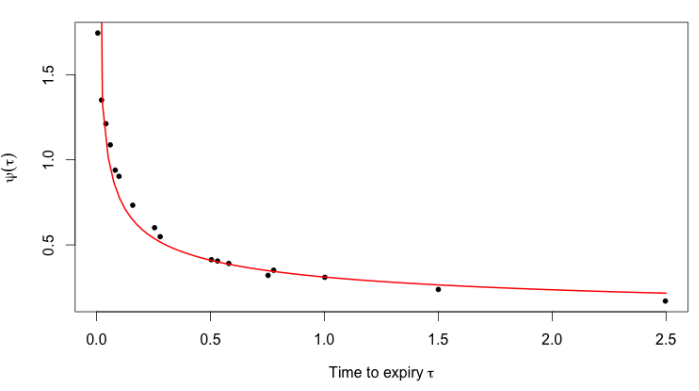

It is known that the colatility driven by the fractional Brownian motion with Hurst exponent $H$ generates an ATM skew of the form $\psi(\tau) \sim \tau^{H-0.5}$.

__Counter argument__: jump processes.

## Conclusions

- The estimate of $\mathbb{H}$ significantly depends on the diameter of subpartition in RV and model parameters.
- w-estimation becomes very unstable when applied to the RV process.
- The proposed methods can hardly be used to obtain a sensible estimatiion of the Hurst exponent of instantaneous volatility based only on the observations of realized volatility.
- The observed "roughness" may be caused by both instantaneous volatility behavior and noise arising from its evaluation.

### Speed of convergence?

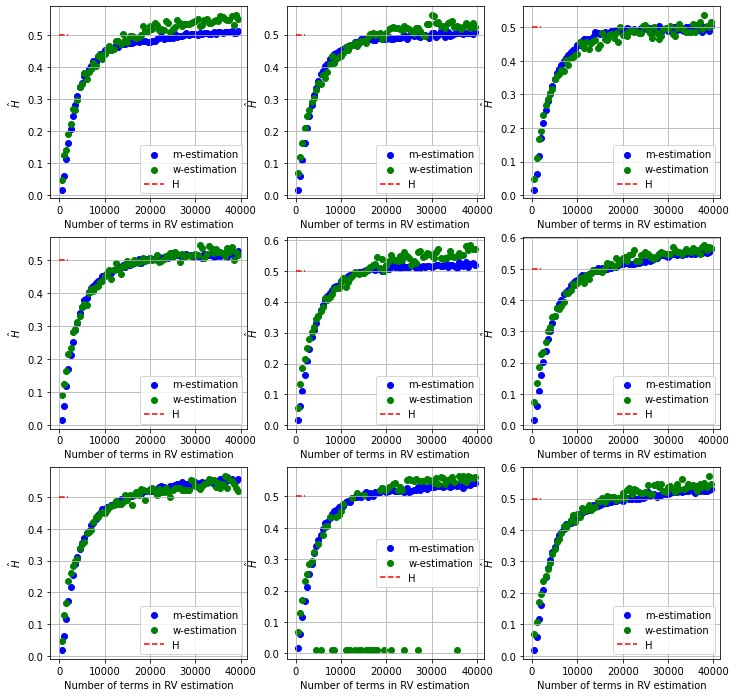

#### Conclusion: the exponential Gaussian white noise is a reasonable model

In [73]:
ETA = 0.0065
signal = gBM[(n_est-1)::n_est]
n_days = signal.size
X = signal * np.exp(np.sqrt(ETA)*np.random.randn(n_days))

In [74]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Scatter(y=X, name='gBM + noise'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(y=signal, name='gBM'),
    row=2, col=1
)

fig.update_layout(height=600, width=800, title_text="gBM corrupted with white noise")
fig.show()

0.12948911169243263

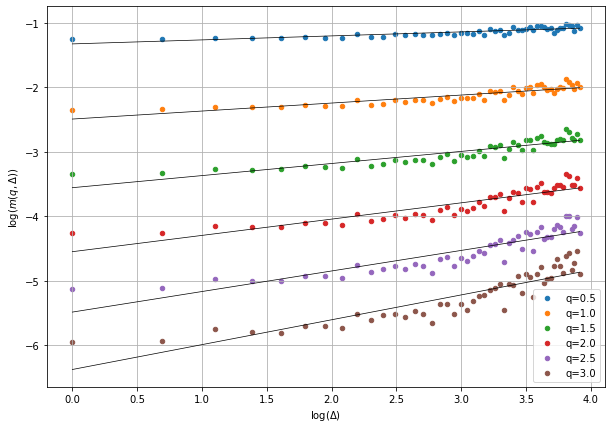

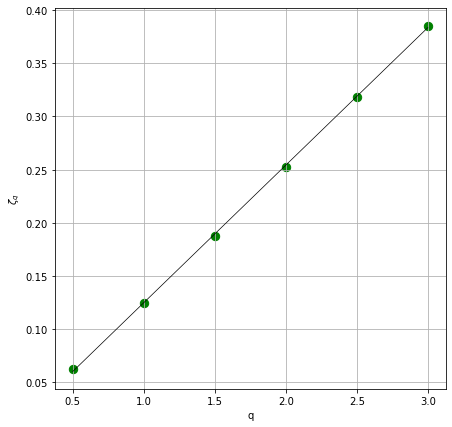

In [50]:
analyze_traj(X, is_plotting=True)

### m-estimation for noisy data

Suppose for simplicity that instantaneous volatility follows geometric Brownian motion
$$ \sigma_t = e^{W_t}. $$
The observed data is corrupted by a Gaussian white noise in the following way:
$$ \tilde\sigma_t = \sigma_t e^{\varepsilon_t}, \quad \varepsilon_t \sim \mathcal{N}(0, \eta) \ \ \text{i.i.d.}$$
In the simulation $\eta_n \approx \dfrac{0.52}{n}$, where $n$ is a size of group in RV estimation.

The value of $m(q, \Delta)$ estimates $\mathbb{E}|\log(\tilde\sigma_{k\Delta}) - \log(\tilde\sigma_{(k-1)\Delta})|^q$, which can be directly calculated in our model:

$$\mathbb{E}|\log(\tilde\sigma_{k\Delta}) - \log(\tilde\sigma_{(k-1)\Delta})|^q = \mathbb{E}|W_{k\Delta} - W_{(k-1)\Delta} + \varepsilon_{k\Delta} - \varepsilon_{(k-1)\Delta}|^q = K_q (\Delta + 2\eta)^{\frac{q}{2}}.$$

Here $K_q$ denotes $q$-th absolute moment of standatd normal distribution.

The regression then has the form
$$ \dfrac{q}2\log(\Delta + 2\eta) \sim \zeta_q\log\Delta + b.$$

In general, if 
$$ 
\sigma_t = e^{\sigma W_t^\mathbb{H}},
$$
we otain
$$ \mathbb{E}\, m(\Delta, q) = K_q(\sigma^2 \Delta^{2\mathbb{H}} + 2\eta)^\frac{q}2,$$
$$ \log\mathbb{E}\, m(\Delta, q) = \dfrac{q}2\log(\sigma^2 \Delta^{2\mathbb{H}} + 2\eta) + \log K_q \sim \zeta_q\log\Delta + b.$$

#### Why does it look like sigmoid?

We are fitting
$$ \dfrac{q}2\log(\Delta + 2\eta) \sim \zeta_q\log\Delta + b,$$
or equivalently
$$ f(x) = \dfrac{q}2\log(e^x + 2\eta) \sim \zeta_q x + b,$$
$$f'(x) = \dfrac{q}{2\left(1 + 2\frac{\eta}{\Delta}\right)}, \quad \zeta_q = \dfrac{q}{2\left(1 + 2\frac{\eta}{\tilde\Delta}\right)}.$$

### Scaling explanation

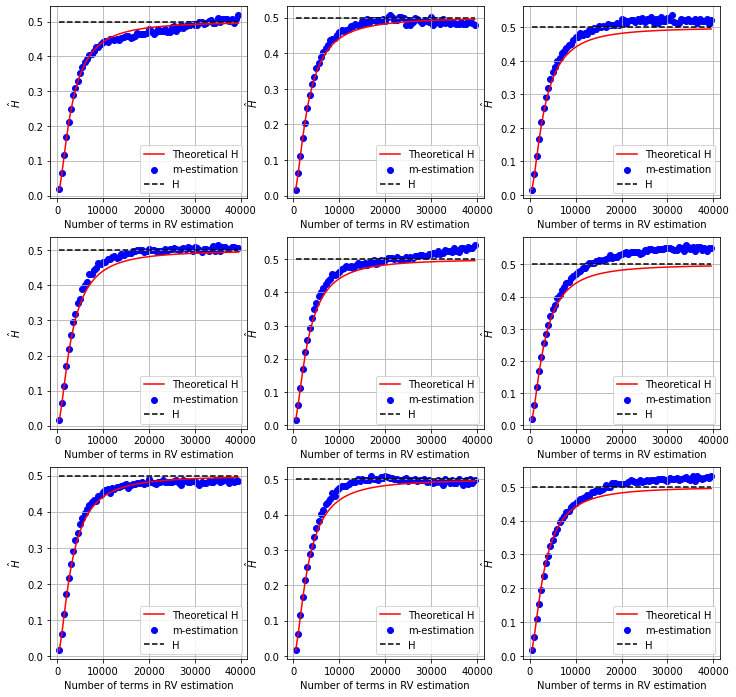